# Mining Big Data to Extract Patterns and Predict Real-Life Outcomes

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

### 1. 预处理

In [2]:
# 读取数据
data = pd.read_csv('users-likes.csv')
data_users = pd.read_csv('users.csv')
data_likes = pd.read_csv('likes.csv')
data = data.merge(data_users, how='inner', on='userid')
data = data.merge(data_likes, how='inner', on='likeid')
data['val'] = pd.Series([1]*data.shape[0])
data.head(6)

,userid,likeid,gender,age,political,ope,con,ext,agr,neu,name,val
0,71bc7c0901488aec6d30f0add257e7c5,3c1636c878e6eb2acfd00c6b61086e38,1,37,NaN,0.61,1.36,-0.21,1.57,0.74,REIGN by Paul Gibson,1
1,71bc7c0901488aec6d30f0add257e7c5,0b587fcf3266aae62fc0b22c43ff275e,1,37,NaN,0.61,1.36,-0.21,1.57,0.74,1 Million People Saying Shame on Arizona,1
2,46e58d38831dfe1913dbe70b5864ce65,0b587fcf3266aae62fc0b22c43ff275e,0,26,NaN,-0.41,-1.45,1.29,-0.59,0.55,1 Million People Saying Shame on Arizona,1
3,a55e2a439106504d8a4182538e88d08a,0b587fcf3266aae62fc0b22c43ff275e,1,61,0.0,1.52,-0.02,0.42,1.49,-0.05,1 Million People Saying Shame on Arizona,1
4,6e737ed1c5acb97ff603666fad32791f,0b587fcf3266aae62fc0b22c43ff275e,1,26,NaN,-0.50,-1.23,0.42,-1.56,-0.82,1 Million People Saying Shame on Arizona,1
5,de072aeed0dc558549491c06afd48e07,0b587fcf3266aae62fc0b22c43ff275e,1,27,NaN,-0.24,0.93,-0.08,-1.01,-1.63,1 Million People Saying Shame on Arizona,1


In [3]:
# 对矩阵的稀疏行列进行修剪

In [4]:
data_trimmed1 = data.filter(items=['userid','val']).groupby('userid')
data_trimmed2 = data.filter(items=['likeid','val']).groupby('likeid')
while pd.DataFrame(data_trimmed1['val'].sum() <= 50).any().val or pd.DataFrame(data_trimmed2['val'].sum() <= 150).any().val:
    data_trimmed1 = data_trimmed1.filter(lambda x: x['val'].sum() > 50)
    data_trimmed2 = data_trimmed2.filter(lambda x: x['val'].sum() > 150)
    data_trimmed1 = data_trimmed1.groupby('userid')
    data_trimmed2 = data_trimmed2.groupby('likeid')

In [5]:
data_trimmed1 = pd.DataFrame(data_trimmed1, columns=['userid','_x'])
data_trimmed2 = pd.DataFrame(data_trimmed2, columns=['likeid','_y'])
data_trimmed1 = data_trimmed1.drop_duplicates('userid')
data_trimmed2 = data_trimmed2.drop_duplicates('likeid')

In [6]:
data_trimmed = data.merge(data_trimmed1, how='inner', on='userid')
data_trimmed = data_trimmed.merge(data_trimmed2, how='inner', on='likeid')
data_users_trimmed = data_users.merge(data_trimmed['userid'], how='inner', on='userid')
data_likes_trimmed = data_likes.merge(data_trimmed['likeid'], how='inner', on='likeid')

In [7]:
data_trimmed = data_trimmed.drop(columns=[ '_x','_y'])
print(data_trimmed.shape, data_users_trimmed.shape, data_likes_trimmed.shape)

(4600071, 12) (4600071, 9) (4600071, 2)


In [8]:
M = data_trimmed.pivot(index='userid', columns='likeid', values='val')

In [9]:
# 存储修剪后的矩阵
M.to_csv('trimmed_M.csv', index=True)
data_users_trimmed.to_csv('data_users_trimmed.csv', index=False)
data_likes_trimmed.to_csv('data_likes_trimmed.csv', index=False)

### 2. 降维

In [13]:
# 读取数据
data_users = pd.read_csv('data_users_trimmed.csv').drop_duplicates('userid').reset_index(drop=True)
M_df = pd.read_csv('trimmed_M.csv') 
M_df = M_df.set_index('userid')
M = M_df.to_numpy(copy=True, na_value=0)

In [ ]:
# SVD

In [15]:
M_sparse = csr_matrix(M)
M_svd = TruncatedSVD(n_components=5, random_state=42)
M_svd.fit(M_sparse)

TruncatedSVD(n_components=5, random_state=42)

In [16]:
transformer = FactorAnalysis(rotation='varimax')
V_rot = transformer.fit_transform(M_svd.components_.T)
U_rot = np.matmul(M, V_rot)

In [33]:
cor_svd = np.array([[np.corrcoef(U_rot[:,i], data_users.iloc[:,j])[0,1] for i in range(0,5)] for j in range(1,9)])

In [ ]:
# LDA

In [56]:
M_lda = LatentDirichletAllocation(n_components=5, doc_topic_prior=10, topic_word_prior=0.1, learning_method='online', random_state=0)
M_lda.fit(M.T)
gamma = M_lda.components_
beta = M_lda.exp_dirichlet_component_
M_lda.bound_

12914.29374775859

In [69]:
cor_lda = np.array([[np.corrcoef(gamma[i,:], data_users.iloc[:,j])[0,1] for i in range(0,5)] for j in range(1,9)])

In [ ]:
# visualization

In [72]:
cor_svd

array([[ 4.26104170e-03,  6.40068295e-03, -5.39531540e-03,
         4.81565383e-03,             nan],
       [ 6.55819008e-03,  6.98605812e-03, -5.58231261e-03,
        -1.08764087e-02,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [ 3.71091689e-03,  7.78073891e-03, -1.10327357e-02,
        -6.85328199e-03,             nan],
       [ 1.63337852e-03,  9.43666448e-04,  6.53681642e-03,
         1.36118880e-02,             nan],
       [-8.47589119e-05,  4.90286493e-04,  1.18830312e-03,
         2.47354692e-03,             nan],
       [ 8.49037655e-03,  1.05160157e-02, -1.41000767e-03,
         1.26289329e-02,             nan],
       [ 2.38670424e-03, -5.90630738e-05, -7.12297883e-03,
        -6.87198689e-03,             nan]])

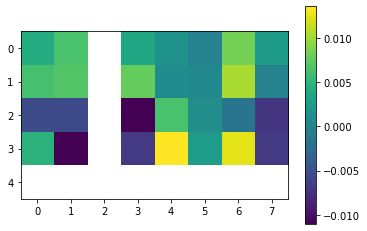

In [60]:
x = np.array(range(0,8))
y = np.array(range(0,5))
X,Y = np.meshgrid(x,y)
plt.imshow(cor_svd[X,Y])
plt.colorbar()
plt.show()

In [70]:
cor_lda

array([[ 0.00336988, -0.00570085,  0.0020255 , -0.00326644,  0.00435744],
       [-0.00235644, -0.00483972, -0.00027497,  0.00894646, -0.00045085],
       [        nan,         nan,         nan,         nan,         nan],
       [ 0.00366819, -0.00503715,  0.00605541,  0.00918986, -0.00257398],
       [ 0.00924779,  0.00346715,  0.00725862, -0.00645731,  0.00424865],
       [ 0.00233665, -0.00304356,  0.0025393 , -0.00068352,  0.00135249],
       [ 0.01441665, -0.00494808,  0.00409512, -0.00346065,  0.01571041],
       [-0.0031606 ,  0.00131042, -0.00747875,  0.0060248 , -0.00085508]])

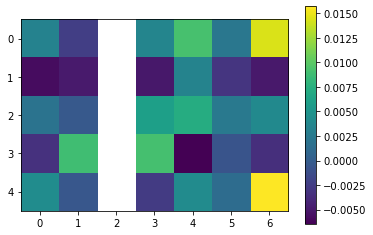

In [71]:
x = np.array(range(0,7))
y = np.array(range(0,5))
X,Y = np.meshgrid(x,y)
plt.imshow(cor_lda[X,Y])
plt.colorbar()
plt.show()

### 3. 预测

In [101]:
data_users = data_users.fillna(0)
model = LinearRegression()
loss_svd = []
loss_lda = []
for j in range(1,9):
    l_svd = -cross_val_score(estimator=model, X=U_rot, y=data_users.iloc[:,j], cv=10, scoring='neg_mean_squared_error').mean()
    l_lda = -cross_val_score(estimator=model, X=gamma.T, y=data_users.iloc[:,j], cv=10, scoring='neg_mean_squared_error').mean()
    loss_svd.append(l_svd)
    loss_lda.append(l_lda)
print(loss_svd)
print(loss_lda)

[0.2455193293034715, 54.9515383691763, 0.07264915003205653, 0.9023364285889031, 0.9814758593091921, 1.0094174816047015, 0.995311433875468, 1.0107472022663773]
[0.24553146321585598, 54.95630356619178, 0.07264533257110425, 0.9023701532905436, 0.9815751587828689, 1.0094356423131605, 0.9953045478747311, 1.010757143166775]


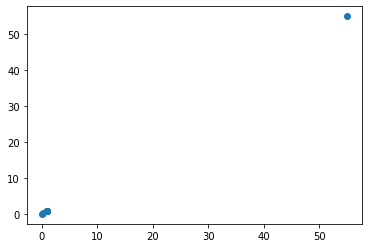

In [102]:
plt.scatter(loss_svd,loss_lda)
plt.show()

**对genre的理解：**

数据是由几个原因导致的或者说可以分解为几个维度，每个原因看做一个genre，通过将数据投影到genre上，得到这组数据关于每个genre的分量。
再通过建立genre与预测值的映射关系，建立起数据与预测值之间的关系。
对于原始数据进行类似“透过现象看本质”的分析，把数据归结到一组genre上，去除噪声信息，防止过拟合。